In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
# Ganti dengan path ke folder FER2013 kamu
DATASET_DIR = r"C:\Users\asus\OneDrive\Dokumen\IPSD Praktikum\FER-2013"

IMG_SIZE = (48, 48)
BATCH_SIZE = 64

train_dir = os.path.join(DATASET_DIR, "train")
test_dir  = os.path.join(DATASET_DIR, "test")

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    validation_split=0.2, 
    subset="training",
    seed=123,               
)

val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [18]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Kelas:", class_names)
print("Jumlah kelas:", num_classes)

Kelas: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Jumlah kelas: 7


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    # dari [0, 255] ke [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_prep = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

val_ds_prep = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

test_ds_prep = (
    test_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

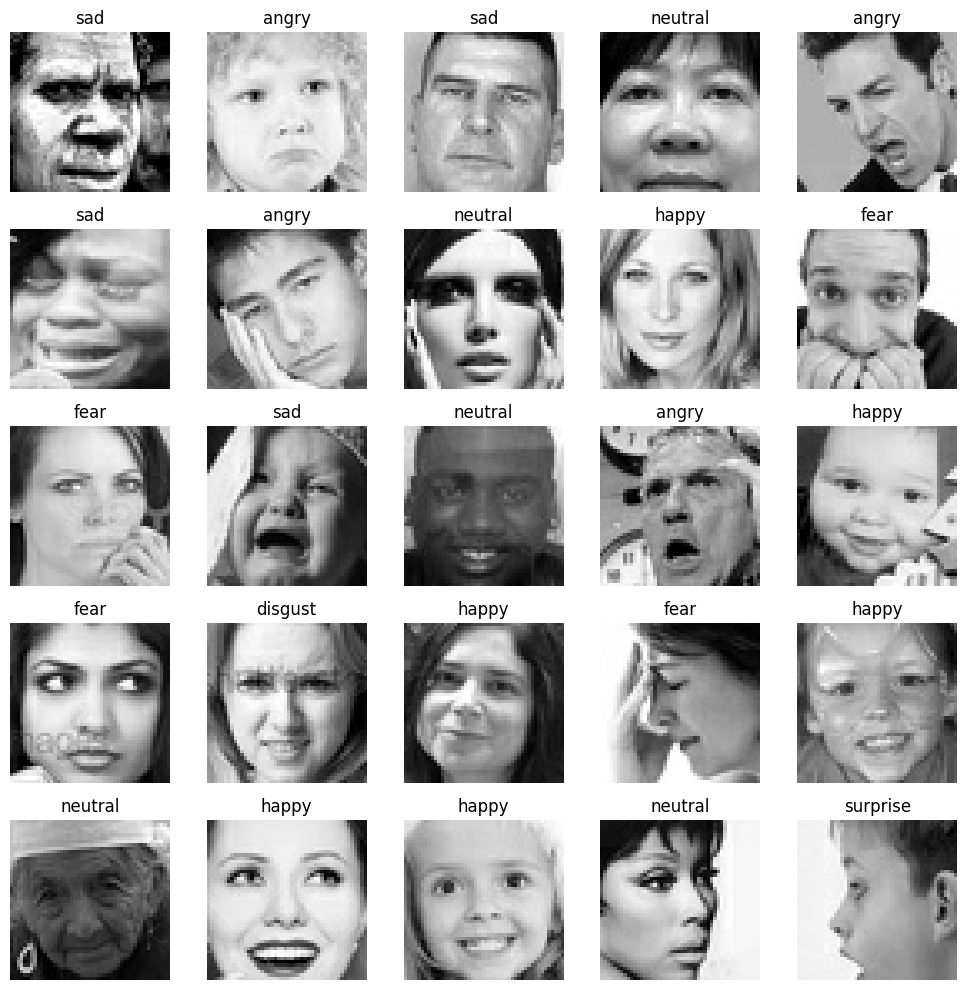

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        # grayscale -> squeeze axis channel
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.15),
        layers.RandomTranslation(0.08, 0.08),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation",
)

In [22]:
input_shape = IMG_SIZE + (1,)
kernel_reg = regularizers.l2(5e-5)

def build_cnn_model_v2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=kernel_reg, activation="relu")(x)
    x = layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=kernel_reg, activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding="same", kernel_regularizer=kernel_reg, activation="relu")(x)
    x = layers.Conv2D(64, (3, 3), padding="same", kernel_regularizer=kernel_reg, activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=kernel_reg, activation="relu")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=kernel_reg, activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Block 4 (kecil saja)
    x = layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=kernel_reg, activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Global Average Pooling instead of Flatten
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="fer2013_cnn_v2")
    return model

model = build_cnn_model_v2(input_shape, num_classes)
model.summary()

Model: "fer2013_cnn_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 651,111 (2.48 MB)

 Trainable params: 650,151 (2.48 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [24]:
checkpoint_path = "best_fer2013_cnn_v2.keras"

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [25]:
EPOCHS = 40

history = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 117ms/step - accuracy: 0.2374 - loss: 1.8811 - val_accuracy: 0.2453 - val_loss: 2.2689 - learning_rate: 3.0000e-04
Epoch 2/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.2857 - loss: 1.7692 - val_accuracy: 0.3113 - val_loss: 1.7322 - learning_rate: 3.0000e-04
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.3362 - loss: 1.6872 - val_accuracy: 0.2442 - val_loss: 1.8688 - learning_rate: 3.0000e-04
Epoch 4/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.3764 - loss: 1.6106 - val_accuracy: 0.3907 - val_loss: 1.5961 - learning_rate: 3.0000e-04
Epoch 5/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.4094 - loss: 1.5305 - val_accuracy: 0.3977 - val_loss: 1.5883 - learning_rate: 3.0000e-04
Epoch 6/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.4381 - loss: 1.4821 - val_accuracy: 0.3372 - val_loss: 1.6958 - learning_rate: 3.0000e-04
Epoch 7/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 11

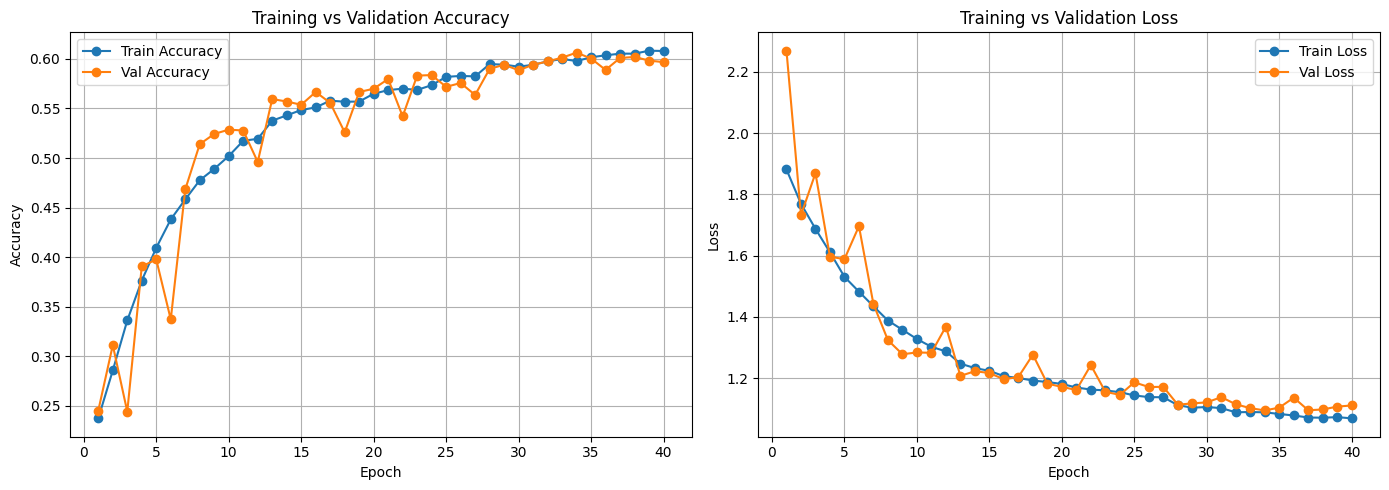

In [26]:
def plot_training_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, marker="o", label="Train Accuracy")
    plt.plot(epochs_range, val_acc, marker="o", label="Val Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, marker="o", label="Train Loss")
    plt.plot(epochs_range, val_loss, marker="o", label="Val Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [27]:
test_loss, test_acc = model.evaluate(test_ds_prep)
print(f"Test Loss  : {test_loss:.4f}")
print(f"Test Acc   : {test_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5975 - loss: 1.1025
Test Loss  : 1.1025
Test Acc   : 0.5975


Confusion Matrix:
 [[ 467    1   94   55  164  145   32]
 [  42    9   15   14    4   24    3]
 [ 148    1  323   51  152  234  115]
 [  49    1   35 1484  122   42   41]
 [  58    0   64   88  815  163   45]
 [ 120    3   96   91  328  580   29]
 [  29    0  105   43   26   17  611]]


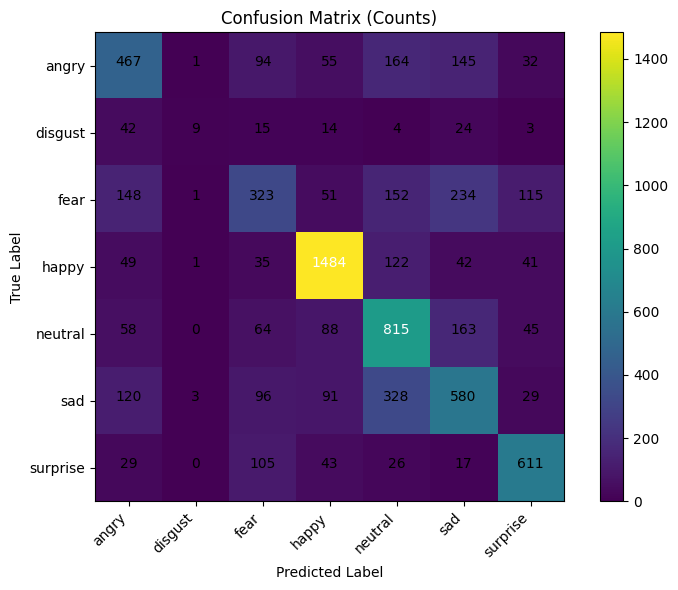

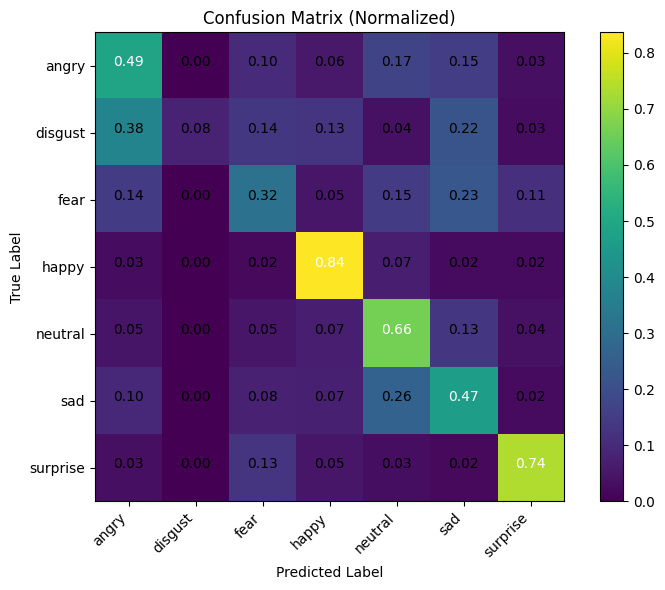

In [28]:
y_true = []
y_pred = []

for images, labels in test_ds_prep:
    preds = model.predict(images, verbose=0)
    preds_cls = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_cls)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix (Counts)")
plot_confusion_matrix(cm, class_names, normalize=True, title="Confusion Matrix (Normalized)")

In [29]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

       angry       0.51      0.49      0.50       958
     disgust       0.60      0.08      0.14       111
        fear       0.44      0.32      0.37      1024
       happy       0.81      0.84      0.82      1774
     neutral       0.51      0.66      0.57      1233
         sad       0.48      0.47      0.47      1247
    surprise       0.70      0.74      0.72       831

    accuracy                           0.60      7178
   macro avg       0.58      0.51      0.51      7178
weighted avg       0.59      0.60      0.59      7178



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


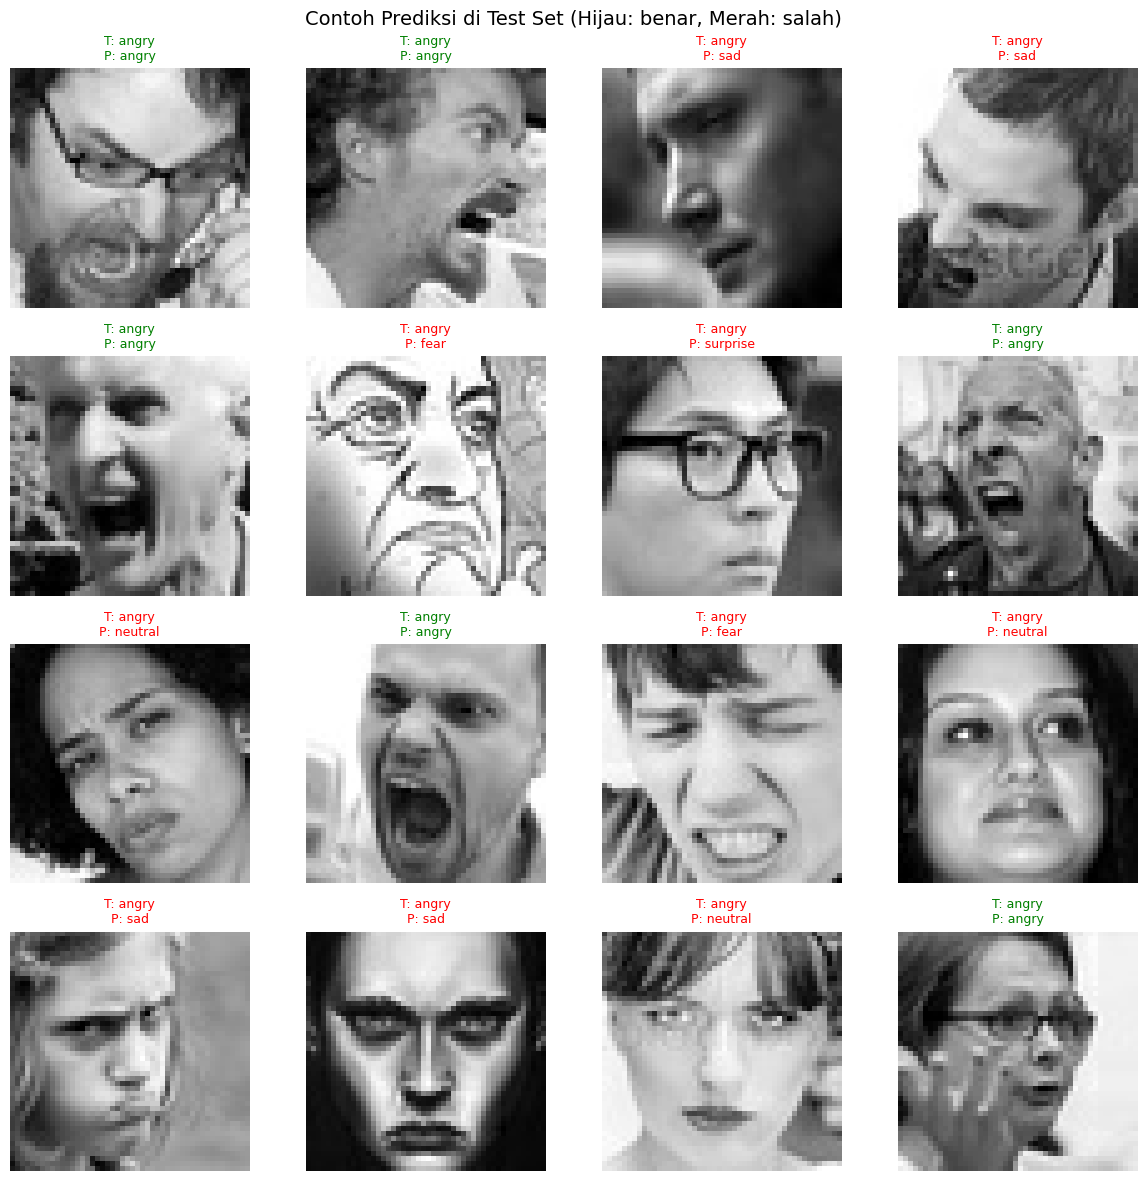

In [30]:
for images, labels in test_ds_prep.take(1):
    preds = model.predict(images)
    preds_cls = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        img = images[i].numpy().squeeze()
        plt.imshow(img, cmap="gray")
        true_label = class_names[labels[i]]
        pred_label = class_names[preds_cls[i]]

        color = "green" if true_label == pred_label else "red"
        plt.title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=9)
        plt.axis("off")
    plt.suptitle("Contoh Prediksi di Test Set (Hijau: benar, Merah: salah)", fontsize=14)
    plt.tight_layout()
    plt.show()
    break